# ASTR4006 Tutorial (Tuesday 26 March 2024):
## Chemistry and Dynamics of the Milky Way

This notebook needs to be in the same location as the FITS-file "APOGEE_DR17_Tutorial.fits"

Author: Sven Buder (sven.buder@anu.edu.au)

## Before you start:

This notebook is a combination of cells that you can simply execute and some cells where you can add your own code.



In [1]:
# Let's load the most important packages

# This is only important for Apple users:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
import astropy.units as u
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import warnings
warnings.filterwarnings("ignore")

## Part 1: Reading in the stellar measurements

In [2]:
try:
    apogee = Table.read('APOGEE_DR17_Tutorial.fits')
except:
    from astropy.io import fits
    fits_file = fits.open('APOGEE_DR17_Tutorial.fits')
    apogee = fits_file[1].data
    fits_file.close()
    
# Some background, if you are really interested:
# APOGEE is a spectroscopic survey collecting infrared spectra for stars of the Milky Way
# It is part of a larger collaboration, the Sloan Digital Sky Survey (SDSS)
# This collaboration is releasing data to the public every ~half year, the latest release was data release nr 17
# I have downloaded a larger table of all APOGEE measurements from here:
# https://www.sdss.org/dr17/data_access/bulk/
# The large table is called "allStar-dr17-synspec_rev1.fits"
# Because the file is 4GB large, I have already trimmed it down to the necessary information for this tutorial
# and got rid of unreliable measurements.
# In particular, I applied the following TRUE/FALSE quality cuts:
# aspcapflag == 0 & fe_h_flag == 0 & mg_fe_flag == 0 & mn_fe_flag == 0 & al_fe_flag == 0 & GAIAEDR3_PARALLAX > 0 & GAIAEDR3_PARALLAX/GAIAEDR3_PARALLAX_ERROR > 5 & snr > 50

In [3]:
# Let's get an idea of what is saved in this file
print(apogee.keys())

['TMASS_ID', 'RA', 'DEC', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMDEC', 'VHELIO_AVG', 'FE_H', 'MG_FE', 'AL_FE', 'MN_FE']


In [4]:
# You see that these keywords are sometimes quite technical, so let's disentangle that:
# TMASS_ID          : Unique Identifier of the star (here: in the catalog of the 2-Micron All-Sky Survey 2MASS)
# RA                : Right Ascension / degrees
# DEC               : Declination / degrees
# GAIAEDR3_PARALLAX : Parallax measured by the Gaia satellite (early data release 3) / mas
# GAIAEDR3_PMRA     : Proper Motion along Right Ascension
# GAIAEDR3_PMDEC    : Proper Motion along Declination
# VHELIO_AVG        : Radial (or line-of-sight) velocity / km/s
# FE_H              : Iron abundance [Fe/H] (logarithmic number density of iron to hydrogen after subtracting the solar ratio)
# MG_FE             : Magnesium abundance [Mg/Fe] (logarithmic number density of magnesium to iron after subtracting the solar ratio)
# Al_FE             : Aluminium abundance [Al/Fe] (logarithmic number density of aluminium to iron after subtracting the solar ratio)
# MN_FE             : Manganese abundance [Mn/Fe] (logarithmic number density of manganese to iron after subtracting the solar ratio)

## Part 2: Preparing more useful coordinates with coordinate transformations

While the positions of RA and DEC are useful for especially for observers (because a star moves along only the RA angle during a night), they are not very intuitive when looking at the Galaxy. We will therefore transform them into a more reasonable coordinate frame, where the Galactic Centre is in the middle.

a) Let's first add units to the 3D positions and 3D velocities

In [5]:
#_____coordinate transformation_____
#input coordinates as quantities with units:
ra       = np.array(apogee['RA'])                   *u.degree     #right ascension [deg] in ICRS
dec      = np.array(apogee['DEC'])                  *u.degree     #declination [deg] in ICRS
distance = 1./np.array(apogee['GAIAEDR3_PARALLAX']) *u.kpc        #distance from Sun [kpc]
pm_ra    = np.array(apogee['GAIAEDR3_PMRA'])        *u.mas/u.year #proper motion in direction of right ascension [mas/yr] in ICRS
pm_dec   = np.array(apogee['GAIAEDR3_PMDEC'])       *u.mas/u.year #proper motion in direction of declination [mas/yr] in ICRS
v_los    = np.array(apogee['VHELIO_AVG'])           *u.km/u.s     #line-of-sight velocity [km/s]

b) There are many tools available to transform coordinates

In [6]:
# Tool 1: astropy.coordinates (we will use later)
try:
    import astropy.coordinates as coord
except:
    pass
    
# Tool 2: galpy.orbit (you likely do not have it installed)
# I want to at least give a shoutout to this great program by Jo Bovy, since I use it a lot in my work
try:
    import galpy.orbit
except:
    print("galpy is not installed - it's a great tool for all kinds of orbit calculations (for example orbit energies). Feel free to check out https://docs.galpy.org/en/v1.6.0/")

A new version of galpy (1.9.2) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


b) Defining our coordinate frame: The Sun's position in the Galaxy

In [7]:
# Let's first input the 6D information to astrpy
coordinates = coord.SkyCoord(
    ra=ra,
    dec=dec,
    distance=distance,
    pm_ra_cosdec=pm_ra,
    pm_dec=pm_dec,
    radial_velocity=v_los,
    frame='icrs' # This is defining the Reference Frame that our Coordinates are living in;
    # ICRS is the International Celestial Reference Frame, where the Galactic Centre is at
    # (RA,Dec) = (266.4051, -28.936175) deg
)

Now these coordinates and velocities are not relative to the Galactic Centre, but to Equatorial Coordinate System. In this system, a star's position is described with (RA,Dec,Distance) with respect to the Sun.

So let's transform this coordinate system into a more useful one, namely a Galactocentric one.
In this coordinate system, we will be able to describe a stars position with (R,phi,z) with respect to the Galactic Centre and Plane.

In order to transform the coordinates, we need to know some important parameters:
1) Where is the Galactic Centre in (RA,Dec)?  
2) How far is the Sun away from the Galactic Centre?  
3) How does the Sun move relative to the Galactocentric Rest Frame?

Luckily, we can rely on measurements or definitions of certain frames.  
For example, per current definition, the Galactic Centre is at (RA,Dec) = (266.4051, -28.936175)

In [8]:
# In addition to the position of the Galactic Centre in (RA,Dec), we also have to give some information
# on the position and motion of the Sun relative to it
# astropy has its own default values, but we have actual measurements that we can use:

r_sun_galactic_centre = 8.178*u.kpc # Gravity Collaboration, 2019, A&A, 625, 10
phi_sun_galactic_centre = 0.0*u.rad # This is just for completeness
z_sun_galactic_plane = 25.0*u.pc # Bland-Hawthorn & Gerhard, 2016, ARA&A, 54, 529

The last piece of information that we need, is the motion of the Sun relative to Galactocentric Rest Frame.
We define the restframe along the line between Sun and Galactic Centre, that actually is on the Galactic plane (so just a bit below the Sun)

That area is the Local Standard of Rest and moves with the circular velocity of the Galaxy at that distance.

<img src="figures/Karttunen_Springer_2007fuas.conf.....K_Fig17_5.png" alt="drawing" width=50%/>

**Figure**: Visualisation of the Local Standard of Rest (LSR) by Karttunen et al. (2007): Fundamental Astronomy, Edited by H. Karttunen, P. Krüger, H. Oja, M. Poutanen, and K.J. Donner. Berlin: Springer. 

In [9]:
# Reid & Brunthaler (2004, ApJ, 616, 872) have further measured the total angular motion of the Sun with respect to the Galactic Centre
v_total_sun = (np.tan(6.379*u.mas)*r_sun_galactic_centre/u.yr).to(u.km/u.s) # pm_l by Reid & Brunthaler 2004, ApJ, 616, 872
# And Schoenrich, Binney and Dehnen (2010, MNRAS, 403, 1829) have measured the motion of the Sun relative to the Local Standard of Rest
v_peculiar = [11.1, 12.24, 7.25]*u.km/u.s # U and W from Schoenrich, Binney, Dehnen, 2010, MNRAS, 403, 1829, V so that V = V_total-V_sun
# We can therefore find the Solar motion as
galcen_v_sun = [11.1, v_total_sun.value, 7.25]*u.km/u.s
print(galcen_v_sun)

# Let's define the Galactocentric Reference Frame, but use our better value of the Distance
galactocentric_frame= coord.Galactocentric(
    galcen_distance=r_sun_galactic_centre,
    galcen_v_sun=coord.CartesianDifferential(galcen_v_sun),
    z_sun=z_sun_galactic_plane
)

# Now let's transform the coordinates to the Galactocentric Cartesian Frame (X,Y,Z) relative to the Galactic Centre
galcen_coordinates = coordinates.transform_to(galactocentric_frame)
# If you want to look under the hood of how to go from RA,Dce,Distance to X,Y,Z via matrix multiplication, you can check out:
# https://articles.adsabs.harvard.edu/pdf/1987AJ.....93..864J
# If you want to work through the coordinate transformations yourself, I can also recommend Jo Bovy's coordinate transformation scripts
# https://docs.galpy.org/en/v1.6.0/reference/bovycoords.html
# and in particular https://docs.galpy.org/en/v1.6.0/reference/coordsradectolb.html to go from (RA,DEC) to (l,b) - which is by far the most difficult one

# Now we also want to go from X,Y,Z to R,phi,z - which is more useful if we want to compare with other galaxies
# 
galcen_coordinates.representation_type = 'cylindrical'

# Let's get an idea of how these coordinates look like
# Note the slightly different notation:
# R = rho
# phi = phi
# z = z

# vR = d_rho
# vphi (angular) = d_phi (but is an angular velocity noted in mas/yr, so has to be converted to km/s by multiplying with R)
# vphi = d_phi * R
# vz = d_z

print(galcen_coordinates)

[ 11.1        247.29831277   7.25      ] km / s
<SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.178 kpc, galcen_v_sun=(11.1, 247.29831277, 7.25) km / s, z_sun=25.0 pc, roll=0.0 deg): (rho, phi, z) in (kpc, deg, kpc)
    [( 8.54332876, 175.37028406, -0.03525912),
     ( 8.54332876, 175.37028406, -0.03525912),
     ( 8.51742491, 175.6504511 , -0.03693558), ...,
     (11.15112017, 157.20900332, -0.40227089),
     ( 9.45252692, 167.05671031, -0.16741739),
     ( 9.8422622 , 164.21880222, -0.28301218)]
 (d_rho, d_phi, d_z) in (kpc mas / (rad yr), mas / yr, kpc mas / (rad yr))
    [(-1.10952795, -5.70252027, -0.49890332),
     (-1.09765964, -5.70485924, -0.50072751),
     ( 1.83075737, -5.63648293, -8.0319879 ), ...,
     (-3.59115864, -4.5931501 ,  2.21265502),
     (-0.7863779 , -4.49397806, -3.53069652),
     ( 0.56265984, -4.63536578,  6.57172111)]>


In [10]:
# Let's save the values in the correct units
R_kpc   = galcen_coordinates.rho.to(u.kpc).value
phi_rad = galcen_coordinates.phi.to(u.rad).value
z_kpc   = galcen_coordinates.z.to(u.kpc).value

vR_kms = galcen_coordinates.d_rho.to(u.km/u.s).value
vT_kms = -(galcen_coordinates.d_phi.to(u.rad/u.s)*galcen_coordinates.rho.to(u.km)  / (1.*u.radian)).value
vz_kms = galcen_coordinates.d_z.to(u.km/u.s).value

## Part 3: Rotational Velocities of stars in the Milky Way

a) Let's have a first look at the rotational velocity curve (Galactocentric radius R_kpc and rotational velocity vT_kms)

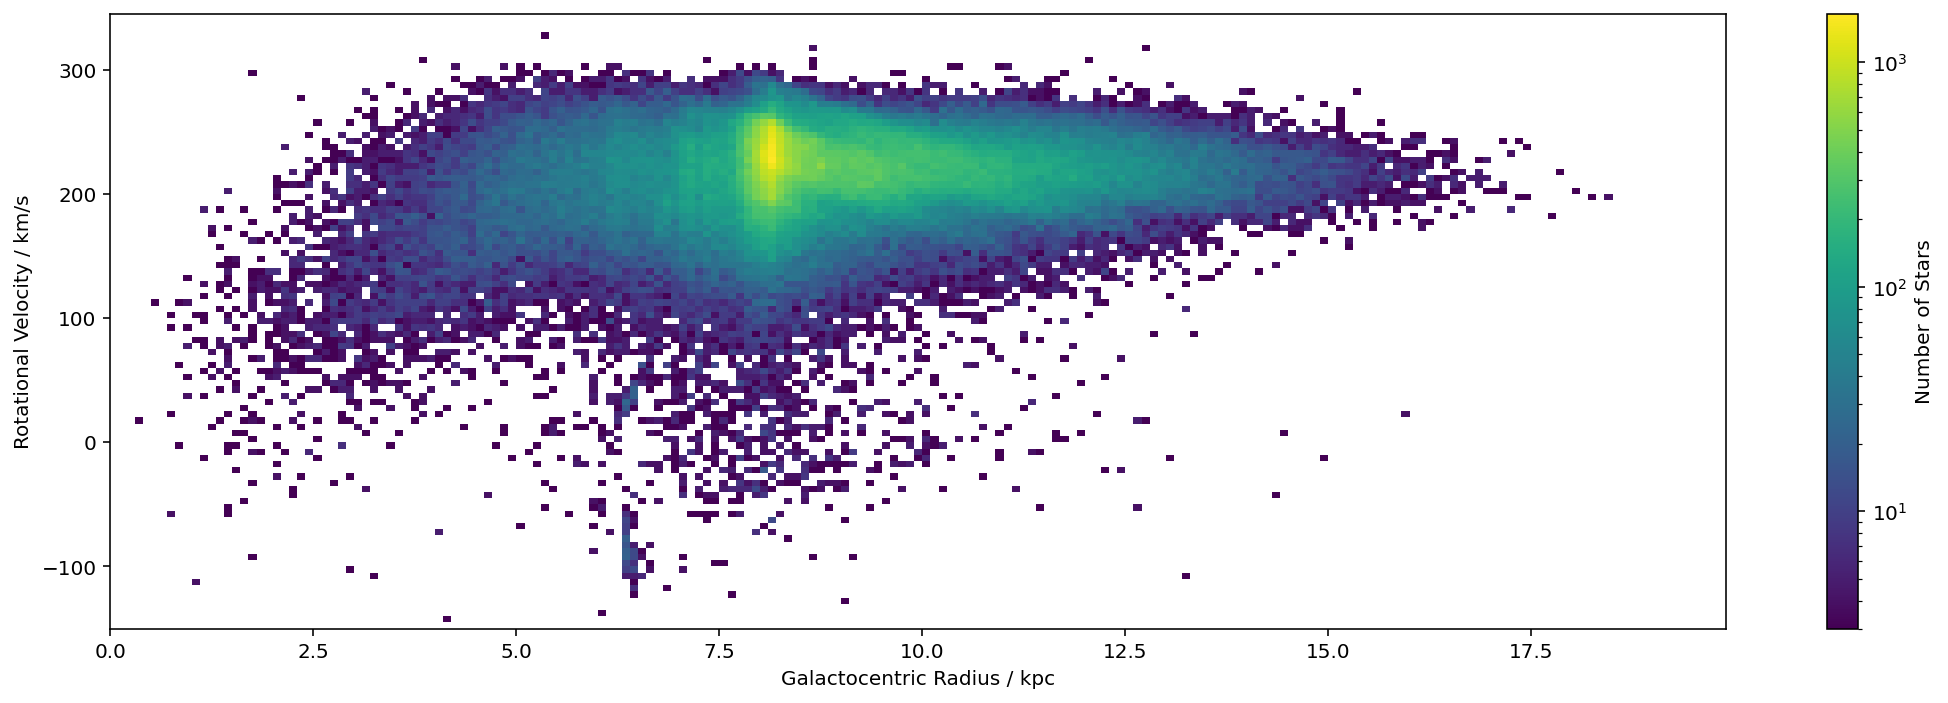

In [11]:
plt.figure(figsize=(15,5))
h = plt.hist2d(
    R_kpc,
    vT_kms,
    bins = (np.arange(0,20,0.1),np.arange(-150,350,5)),
    cmin = 3,
    norm = LogNorm()
);
plt.xlabel('Galactocentric Radius / kpc')
plt.ylabel('Rotational Velocity / km/s')
colorbar = plt.colorbar(h[-1])
colorbar.set_label('Number of Stars')
plt.tight_layout()

What do you see? Can you explain some of the substructure?

Hint for the substructure: We only observe a very biased selection of stars - how far do you think we can look with a 2.5 meter wide telescope? Where would be expect stellar clusters to be located?

b) Let's loop over bins of Galactocentric radius and calculate the median and overplot it

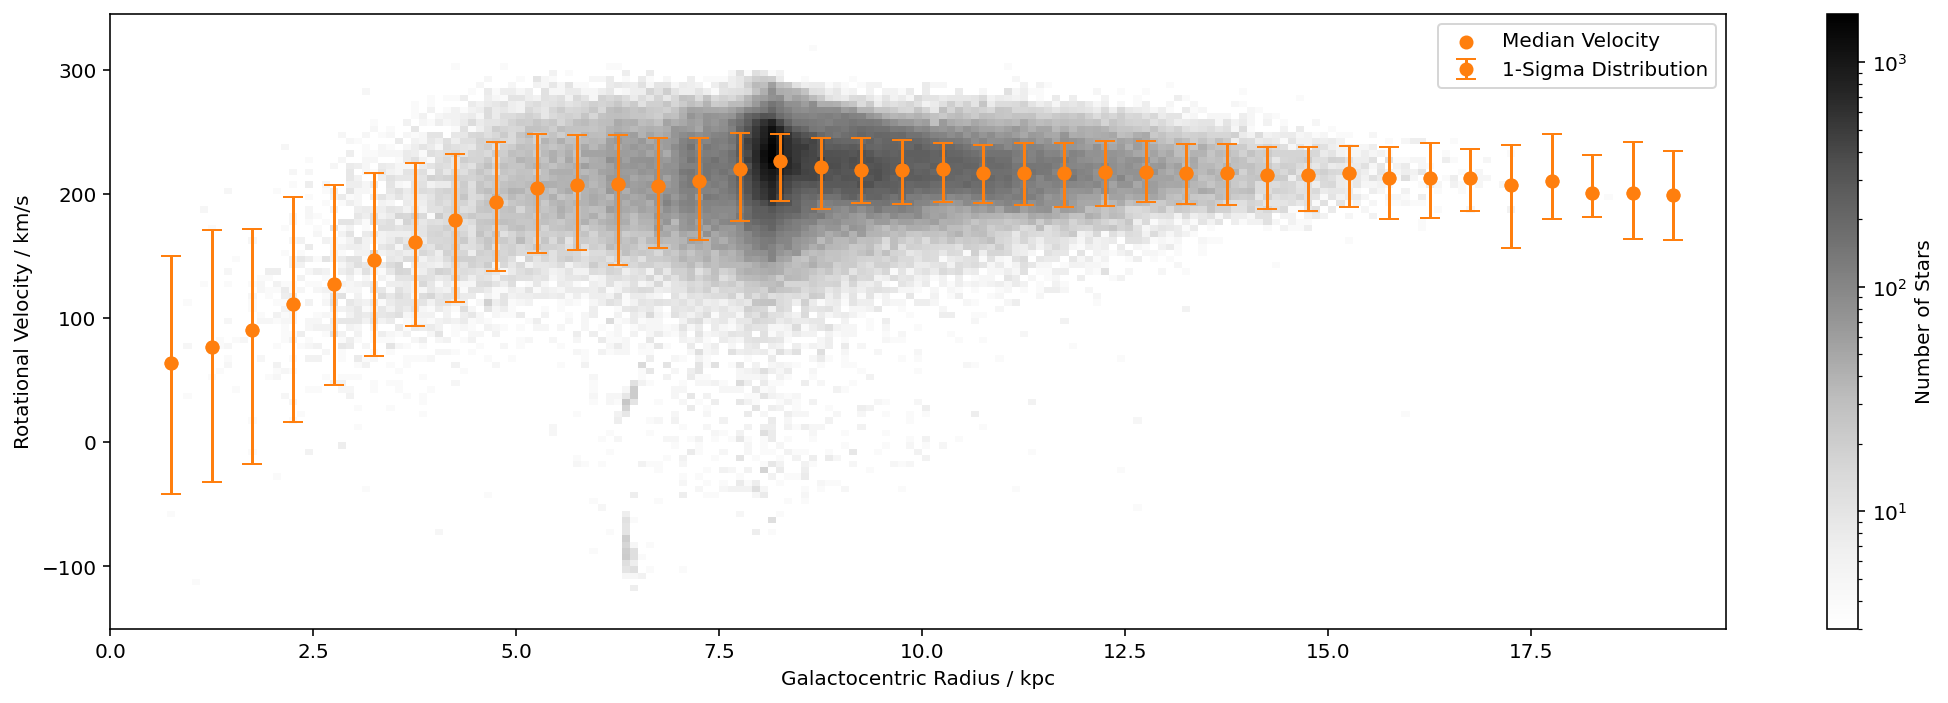

In [12]:
plt.figure(figsize=(15,5))
h = plt.hist2d(
    R_kpc,
    vT_kms,
    bins = (np.arange(0,20,0.1),np.arange(-150,350,5)),
    cmin = 3,
    cmap = 'Greys',
    norm = LogNorm()
);

R_bin_size = 0.5 # kpc
R_bins = np.arange(1,20,R_bin_size)-0.5*R_bin_size

median_v_rot = []

for R_bin in R_bins:
    stars_in_R_bin = (
        (R_kpc > R_bin-0.5*R_bin_size) & 
        (R_kpc < R_bin+0.5*R_bin_size)
    )
    median_v_rot.append(np.median(vT_kms[stars_in_R_bin]))
plt.scatter(
    R_bins,
    median_v_rot,
    label = 'Median Velocity', color = 'C1'
)
    
# We can even try to get an idea of the distribution of velocities in each bin with np.percentile.
# That sorts the velocities and tells the velocity value of the lowest X% stars (50% here is for example the median)
percentiles_v_rot = []

for R_bin in R_bins:
    stars_in_R_bin = (
        (R_kpc > R_bin-0.5*R_bin_size) & 
        (R_kpc < R_bin+0.5*R_bin_size)
    )
    percentiles_v_rot.append(np.percentile(vT_kms[stars_in_R_bin],q=[16,50,84]))

percentiles_v_rot = np.array(percentiles_v_rot)

plt.errorbar(
    R_bins,
    percentiles_v_rot[:,1],
    yerr = [
        percentiles_v_rot[:,1]-percentiles_v_rot[:,0],
        percentiles_v_rot[:,2]-percentiles_v_rot[:,1]
    ],
    capsize=5,
    fmt = 'o',
    label = '1-Sigma Distribution', color = 'C1'
)
    
colorbar = plt.colorbar(h[-1])
colorbar.set_label('Number of Stars')
plt.xlabel('Galactocentric Radius / kpc')
plt.ylabel('Rotational Velocity / km/s')
plt.legend()
plt.tight_layout()

If you want to learn more about this, I highly recommend to read [Eilers et al. (2019)](http://adsabs.harvard.edu/abs/2019ApJ...871..120E):

<img src="figures/Eilers_2019ApJ...871..120E_Fig3.png" alt="drawing" width=50%/>

**Figure**: New measurements of the circular velocity curve of the Milky Way by Eilers et al. (2019)

## Part 4: Abundances of Milky Way Stars

Here we look at some of the abundances of stars in the Milky Way, as measured with the APOGEE Survey.  

From the lecture, you remember that we typically write abundances as logarithmic number density ratios relative to hydrogen or iron and the "[]" denote that we compare it to these logarithmic ratios of the Sun.

Remember logarithmic rules: log(A/B) = log(A/X * X/B) = log(A/X) + log(X/B) = log(A/X) - log(B/X)

That means, for abundances of elements X and Y we can define:     [X/Fe] = [X/H] - [Fe/H]     and    [X/Y] = [X/Fe] - [Y/Fe]

a) Iron abundance [Fe/H] versus Magnesium Abundance [Mg/Fe]: Tracing Star formation intensity and the ratio of Supernovae Type Ia and II

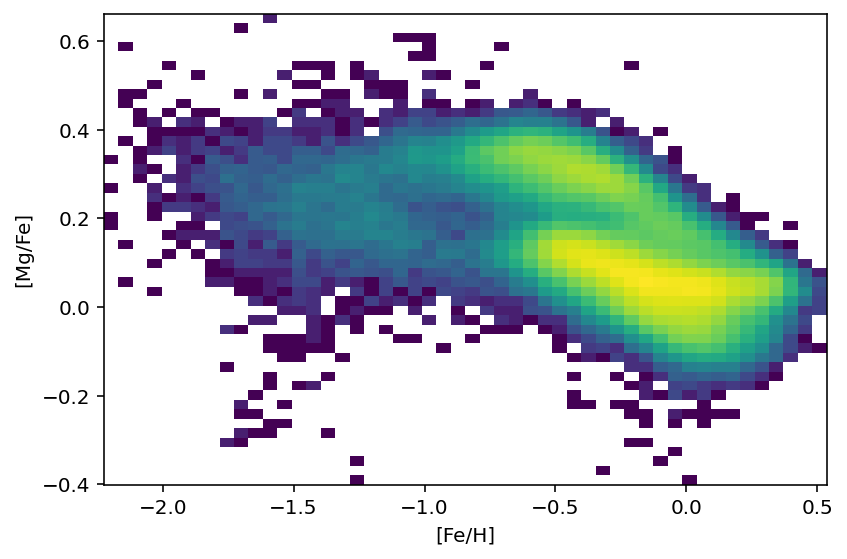

In [13]:
plt.hist2d(
    apogee['FE_H'],apogee['MG_FE'],
    bins = 50,
    cmin = 1,
    norm = LogNorm()
);
plt.xlabel('[Fe/H]')
plt.ylabel('[Mg/Fe]')
plt.tight_layout()

b) How does this look like for [Fe/H] vs. [Al/Fe] and [Fe/H] vs. [Mn/Fe]?

In [14]:
# Plot Here the result for [Fe/H] vs. [Al/Fe]

In [15]:
# Plot Here the result for [Fe/H] vs. [Mn/Fe]

c) Spoiler Alert: The distributions of [Mg/Fe] vs. [Al/Fe] vs. [Mn/Fe] look very different!

The reason is, that :
- Mg is produced predominantly in Supernovae II, 
- Al is also produced by heavy stars, but depends on the amount of metals present
- Mn is mainly produced in Supernovae Ia

So how does a diagram look like, where we plot [Al/Fe] versus the ratio [Mg/Mn] (and how do we best compute [Mg/Mn] in the first place)?

In [16]:
# Plot Here the result for [Al/Fe] vs. [Mg/Mn]

What overdensities do you see? Can you explain them?

# Part 5: Distribution of stars in [Fe/H] vs. [Mg/Fe] across the Galaxy

In the lecture, I showed you the plot by [Hayden et al. (2015)](http://adsabs.harvard.edu/abs/2015ApJ...808..132H), made with 70,000 stars.

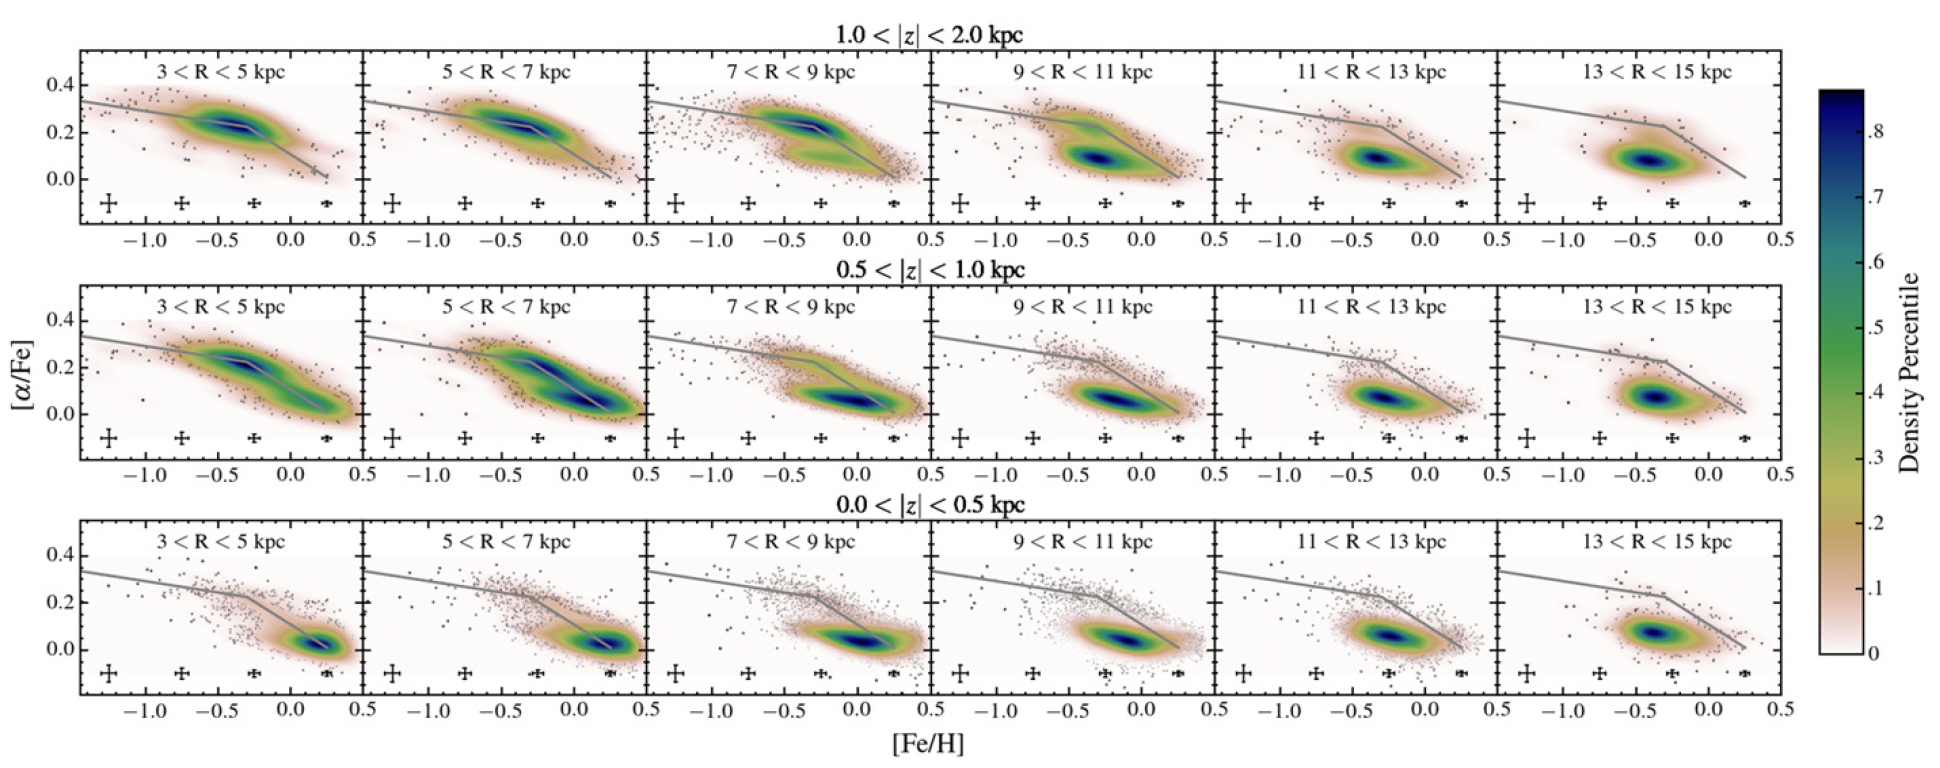

Since then, APOGEE has measured many more stars (in the clean sample I am providing 226,000 for you) and the Gaia satellite has measured stellar positions much more accurately now.

So I think it's time to do this plot again!

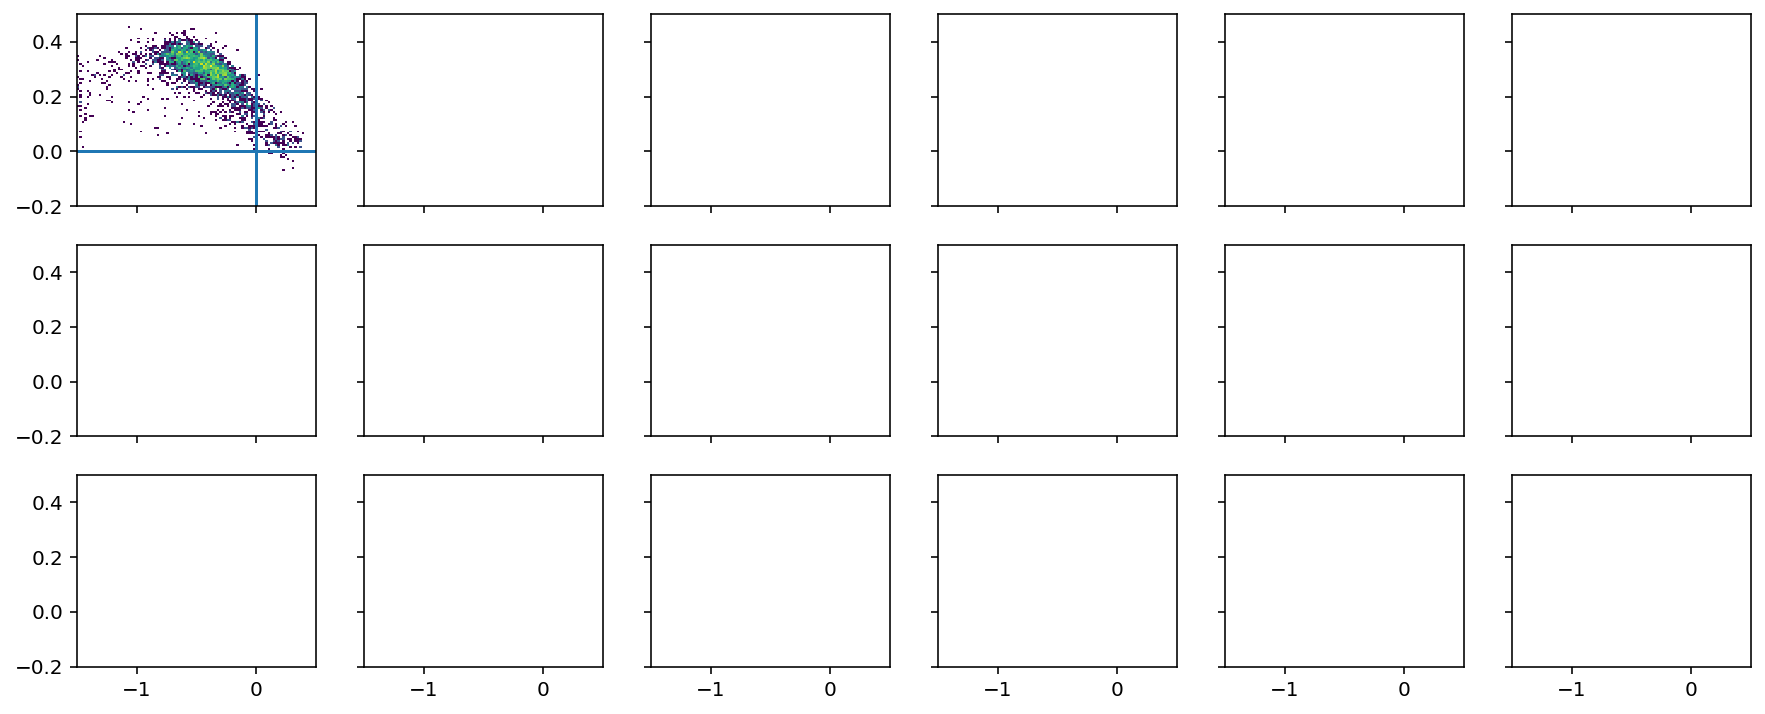

In [17]:
# Plot Here the result for [Fe/H] vs. [Mg/Fe] in bins of the same bins as Hayden et al. (2015).

f, gs = plt.subplots(3,6,figsize=(15,6),sharex=True,sharey=True)

# gs is an array of the subplots, so if you want to plot in the top left subplot, use 
ax = gs[0,0]

#I am just showing you here an example of how you can then plot the 2-dimensional histogram in each subplot (you of course have to adjust that for each of the subplots)
in_this_particular_bin = (
    (3 < R_kpc) & 
    (R_kpc < 5) &
    (1.0 < np.abs(z_kpc))&
    (np.abs(z_kpc) < 2.0)
)

ax.hist2d(
    apogee['FE_H'][in_this_particular_bin],
    apogee['MG_FE'][in_this_particular_bin],
    bins = (
        np.linspace(-1.5,0.5,100),
        np.linspace(-0.2,0.5,100)
    ),
    cmin = 1,
    norm = LogNorm()
);

ax.axhline(0,lw=1.5)
ax.axvline(0,lw=1.5)

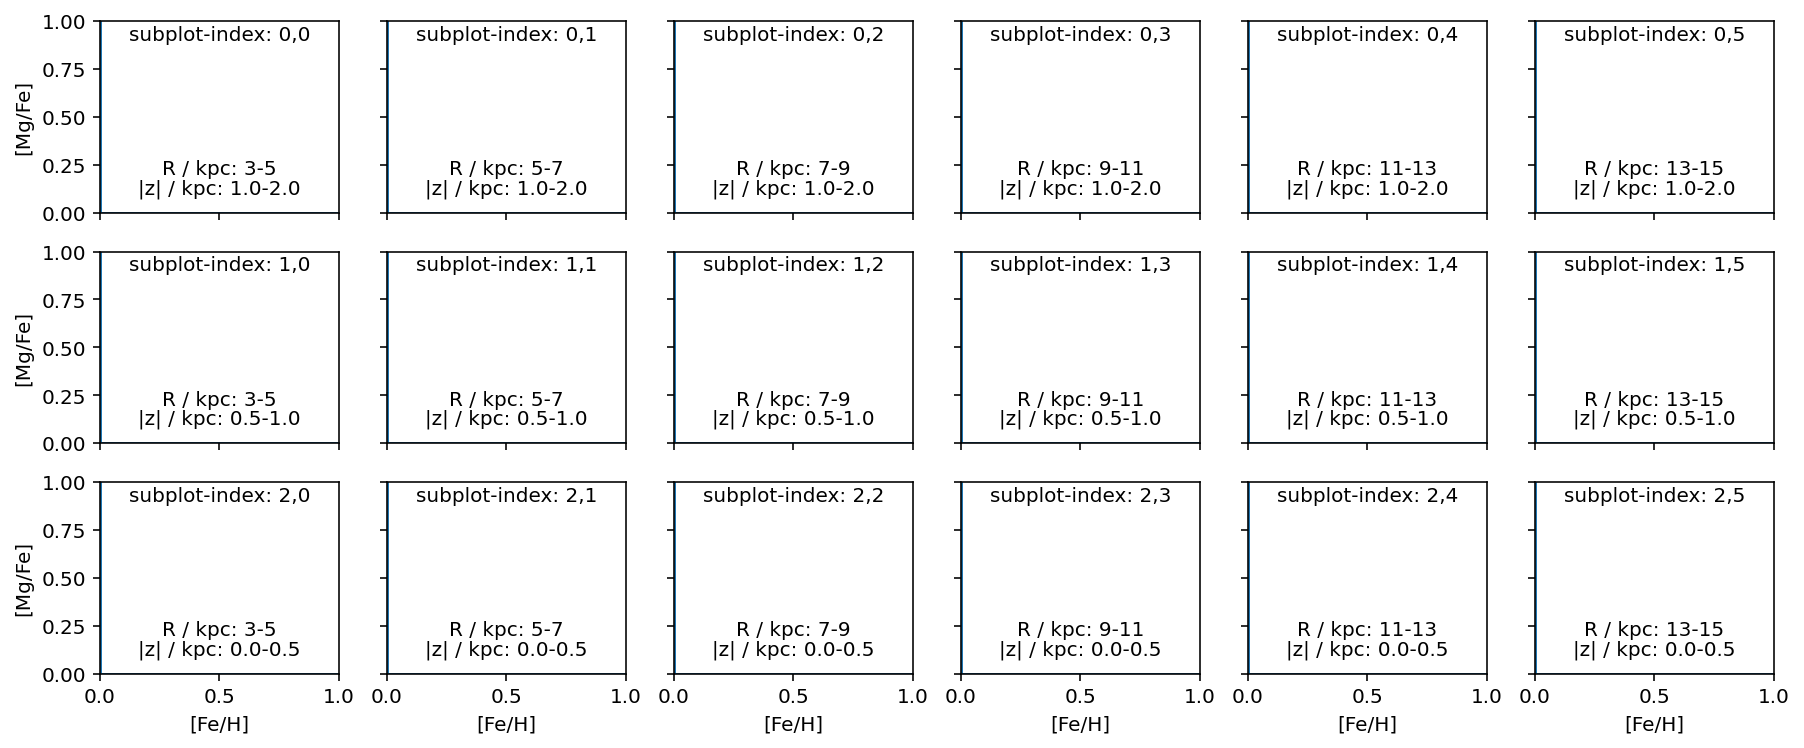

In [18]:
# Hint: You can automate this process, by looping through 2 for-loops. Note: 

f, gs = plt.subplots(3,6,figsize=(15,6),sharex=True,sharey=True)

for R_index,(R_min,R_max) in enumerate(zip([3,5,7,9,11,13],[5,7,9,11,13,15])):
    for z_index,(z_min,z_max) in enumerate(zip([1.0,0.5,0.0],[2.0,1.0,0.5])):

        # gs is an array of the subplots, so if you want to plot in the top left subplot, use 
        ax = gs[z_index,R_index]
        
        # COPY HERE THE SELECTION "in_this_particular_bin" and adjust it
        # COPY HERE THE HIST2D: "ax.hist2d(...)" and adjust it
        
        ax.text(0.5,0.9,'subplot-index: '+str(z_index)+','+str(R_index),transform=ax.transAxes,ha='center')
        ax.text(0.5,0.2,'R / kpc: '+str(R_min)+'-'+str(R_max),transform=ax.transAxes,ha='center')
        ax.text(0.5,0.1,'|z| / kpc: '+str(z_min)+'-'+str(z_max),transform=ax.transAxes,ha='center')
        
        ax.axhline(0,lw=1.5)
        ax.axvline(0,lw=1.5)

        if R_index == 0:
            ax.set_ylabel('[Mg/Fe]')
        if z_index == 2:
            ax.set_xlabel('[Fe/H]')

In [19]:
# If you are way ahead of time, feel free to replicate the same plots, but with [Fe/H] vs. [Al/Fe]

In [20]:
# If you are way ahead of time, feel free to replicate the same plots, but with [Fe/H] vs. [Mn/Fe]

# Part 6: Chemodynamics of the Milky Way

For the last part of our tutorial, we will try to understand the dynamics of the Milky Way when looking at chemically different populations.

Remember our plot of [Al/Fe] vs. [Mg/Mn]? This is how it looked like when [Das et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020MNRAS.493.5195D) worked on a slightly earlier version of the data:
    
<img src="figures/Das_2020MNRAS.493.5195D_Fig3d.png" alt="drawing" width=50%/>

**Figure**: [Al/Fe] vs. [Mg/Mn] abundances of APOGEE DR14 by Das et al. (2020)
    
    

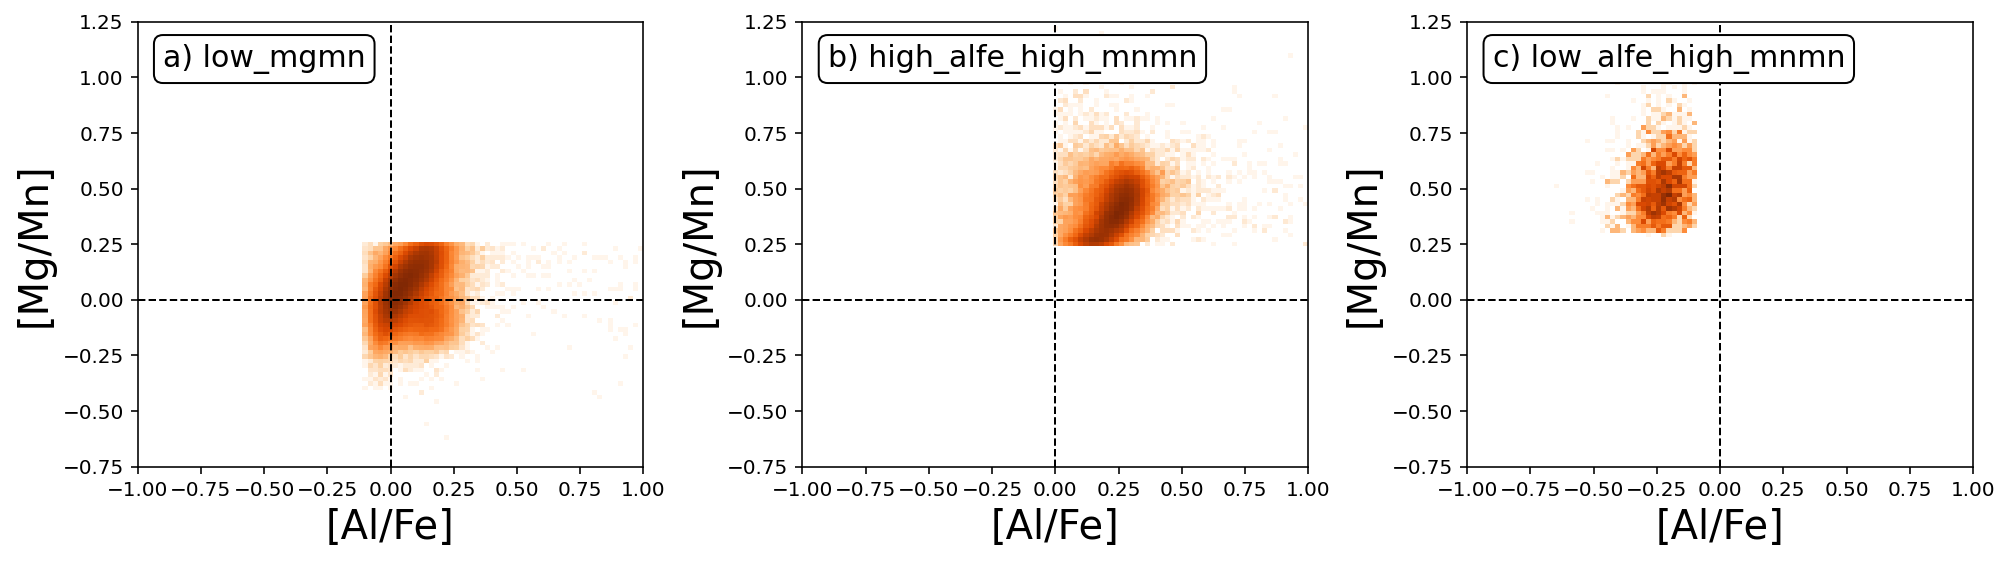

In [21]:
# Let's look at the three overdensities separately
overdensities = dict()
overdensities['low_mgmn'] = (
    (apogee['AL_FE'] > -0.1) &
    (apogee['MG_FE'] - apogee['MN_FE'] < 0.25)
)
overdensities['high_alfe_high_mnmn'] = (
    (apogee['AL_FE'] > 0.0) &
    (apogee['MG_FE'] - apogee['MN_FE'] > 0.25)
)
overdensities['low_alfe_high_mnmn'] = (
    (apogee['AL_FE'] < -0.10) &
    (apogee['MG_FE'] - apogee['MN_FE'] > 0.30)
)

# Let's look at our selection of stars in the [Al/Fe] vs. [Mg/Mn] plane

f, gs = plt.subplots(1,3,figsize=(14,4))
panels = ['a)','b)','c)']

for overdensity_index, overdensity in enumerate(overdensities.keys()):
    
    ax = gs[overdensity_index]
    ax.text(0.05,0.95,panels[overdensity_index]+' '+overdensity,transform=ax.transAxes, fontsize=15, va='top', ha='left',bbox=dict(boxstyle='round', facecolor='w'))
    
    ax.hist2d(
        apogee['AL_FE'][overdensities[overdensity]],
        apogee['MG_FE'][overdensities[overdensity]] - apogee['MN_FE'][overdensities[overdensity]],
        bins = (np.linspace(-1,1,100),np.linspace(-0.75,1.25,100)),
        cmin = 1, cmap = 'Oranges', norm=LogNorm()
    )
    ax.set_xlabel(r'[Al/Fe]',fontsize=20)
    ax.set_ylabel(r'[Mg/Mn]',fontsize=20)
    ax.axhline(0,c='k',ls='dashed',lw=1)
    ax.axvline(0,c='k',ls='dashed',lw=1)
plt.tight_layout()

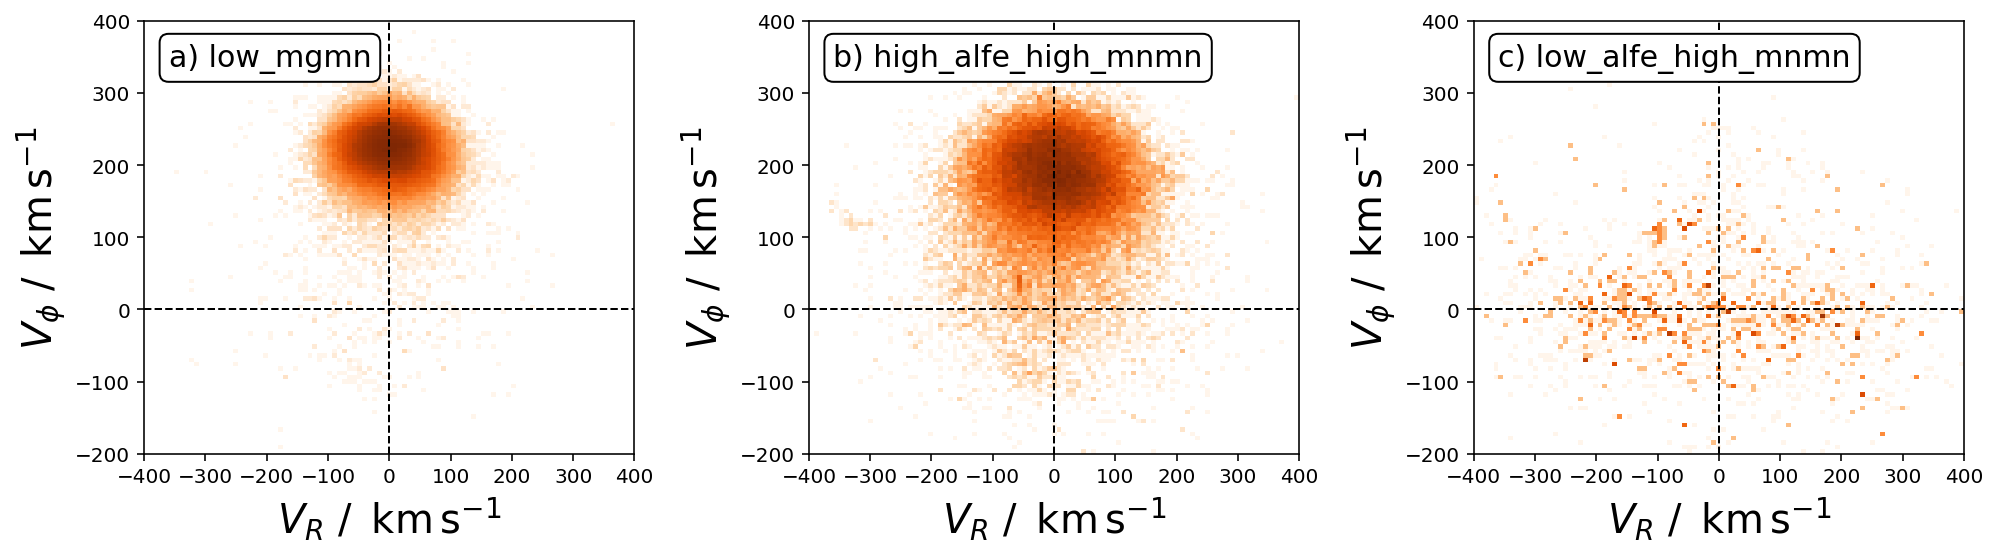

In [22]:
# Now let's look at some of the dynamic quantities:

f, gs = plt.subplots(1,3,figsize=(14,4))
panels = ['a)','b)','c)']

for overdensity_index, overdensity in enumerate(overdensities.keys()):
    
    ax = gs[overdensity_index]
    ax.text(0.05,0.95,panels[overdensity_index]+' '+overdensity,transform=ax.transAxes, fontsize=15, va='top', ha='left',bbox=dict(boxstyle='round', facecolor='w'))
    
    ax.hist2d(
        vR_kms[overdensities[overdensity]],
        vT_kms[overdensities[overdensity]],
        bins = (np.linspace(-400,400,100),np.linspace(-200,400,100)),
        cmin = 1, cmap = 'Oranges', norm=LogNorm()
    )
    ax.set_xlabel(r'$V_R~/~\,\mathrm{km\,s^{-1}}$',fontsize=20)
    ax.set_ylabel(r'$V_\phi~/~\,\mathrm{km\,s^{-1}}$',fontsize=20)
    ax.axhline(0,c='k',ls='dashed',lw=1)
    ax.axvline(0,c='k',ls='dashed',lw=1)
plt.tight_layout()

# What can you infer about the orbits of these three chemical overdensities based on these dynamic plots?